# Table of Contents


### Part I - Preprocessing
---------------------------

1. [View Keys in Root Data](#View-the-Keys-in-the-Imported-Data)

2. [Optimisation Tests I: Python](#Optimisation-Tests)

3. [Data Conversion using Uproot](#Load-Data-into-Arrays)

4. Preprocessing
	- [Optimisation](#Preprocessing-1:-Reformat-List-of-Indices-to-Sets-of-Indices-for-each-Rechit)
	- [Convert to Dataframes](#Preprocessing-2:-Add-all-data-into-dataframes)
	- [Create Global Rechit Dataframe](#Create-a-Global-Dataframe-of-Rechits)

5. [Rechit to Track Matching](#Match-the-Rechits-to-Tracks-and-Create-a-Global-Array-of-Tracks)

6. [Optimisation Tests II: Dataframes](#Test-Performance-of-df.loc-versus-multi-index-retrieval-[-][-])


### Part II: Raw Data Analysis and Plots
-----------------------------------------

1. [Count Data in Track to Rechit Map](#Analyse-the-data-stored-in-the-track_to_rechit_map_)

2. [Generate Match Count Plots](#Generate-Plots)
	- [Counting Matched vs. Unmatched Rechits](#Analyse-Matched/Unmatched-Rechits)
	- [Plot Count of Track and TP Matched Rechits](#Plot-the-Rechits-Matched-to-TP,-Track,-or-Unmatched)

3. Track Analysis
	- [Compare Eta between Tracks and their Rechits](#Compare-Track-and-Matched-Rechit-Eta)
	- [Plot Track Parameter Distribution Histograms](#Plot-Track-Parameters)
	- [Analyse/Filter High-Pt Events](#Filter-High-Pt-Events)

4. Rechit/Simhit Analysis
	- [Plot Simhit Distribution 2D](#Plot-SimHit-Distribution-in-X-and-Y-Axes)
	- [Simhit Match Count](#Count-Simhits-Matched-to-Tracks)
	- [Realistic Geometry Simulation: Hole](#Plot-the-Hole-in-the-Data-(2D-Plot;-3D-Axes))
	- [Plot MonoRechit Distribution 2D](#Visualize-the-Mono-Rechits)
	- [Plot Rechit Parameter Distribution Histograms](#Plot-Rechit-Parameters)
	- [Plot StereoRechit Distribution 2D](#Visualize-the-Stereo-Rechits)

5. Data Storage
	- [Verify Data is not Corrupted](#Testing-Integrity-of-internal-data-storage)
	- [Write Data to Serialized Output Format](#Data-Storage-for-TF/PyTorch/Graph-Library)


### Part III: Filtered (Cut) Data Analysis and Plots
--------------------------------------------------

1. [Place Cuts on Rechits](#Place-the-Cuts-on-Rechits-=>-eta-(-0.9,-0.9))
    - [Scatter Plot of Filtered Rechits](#Plot-the-Hits-without-Connections)

2. [Plot 2D Rechit Parameters](#Plot-the-2D-Rechit-Parameters-for-Filtered-Hits)

3. [Place Cuts on Tracks](#Place-the-cuts-on-tracks-by-Eta-and-Pt)

4. [Plot only Filtered Rechits](#Plot-only-the-filtered-rechits)

5. [Plot Matched/Unmatched Track Distribution](#Plot-Track-Distribution)

In [1]:
% matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from collections import OrderedDict

## View the Keys in the Imported Data

In [2]:
gen_event_ = "ttbar-100"
number_of_events_ = 100
outfile_ = "outfile-" + gen_event_ + ".root"
data_ = uproot.open(outfile_)["ntuples"]["tree"]
# data_.keys()

## Check the Integrity of the Imported Data 

In [3]:
stereo_tp_idx_ = data_.array('stereoTPIndex')
mono_tp_idx_ = data_.array('monoTPIndex')
track_tp_idx_ = data_.array('trackTPIndex')

# Check that both have been generated for the same number of events
# Just for clarity
print len(track_tp_idx_) == len(stereo_tp_idx_),
print len(track_tp_idx_) == len(mono_tp_idx_),
print "\nTotal", len(track_tp_idx_), "events"

True True 
Total 100 events


In [4]:
# Check if any tracks map to multiple tracking particles
for i in range(len(track_tp_idx_)):
    for track_tp_list_ in track_tp_idx_[i]:
        if len(track_tp_list_) > 1:
            print "Track maps to multiple TPs in event", i

In [5]:
%%time

# Check if any hits map to multiple tracking particles
# It is NOT NECESSARY that these TPs map to actual tracks
hit_tp_count_ = {}

# Iterate over event length in mono and stereo rechits
for event_ in range(len(stereo_tp_idx_)):
    for stereo_tp_list_ in stereo_tp_idx_[event_]:
        tp_len_ = len(stereo_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1
    
    for mono_tp_list_ in mono_tp_idx_[event_]:
        tp_len_ = len(mono_tp_list_)
        # Add to a dictionary of <num of TP matches : hit count>
        if tp_len_ in hit_tp_count_:
            hit_tp_count_[tp_len_] += 1
        else:
            hit_tp_count_[tp_len_] = 1

# This prints how many hits map to multiple matches
# <num matches to TPs: ncount of hits>
print "Number of matches and number of hits with those many TP matches\n", hit_tp_count_

Number of matches and number of hits with those many TP matches
{0: 166358, 1: 429164, 2: 4501, 3: 253, 4: 42, 5: 13, 6: 6, 7: 4, 8: 2, 9: 4}
CPU times: user 4.72 s, sys: 41.5 ms, total: 4.76 s
Wall time: 4.81 s


# Optimisation Tests

In [6]:
def list_to_set(input_array_):
    '''
    Format: 3-level nested lists - [[[...] ...] ...]
    '''
    output_array_ = []
    for index_ in range(len(input_array_)):
        output_array_.append([])
        for second_list_ in input_array_[index_]:
            output_array_[index_].append(set(second_list_))
    return output_array_

In [7]:
%%time 
mono_tp_idx_set_ = list_to_set(mono_tp_idx_)

CPU times: user 3.99 s, sys: 68.8 ms, total: 4.06 s
Wall time: 4.1 s


In [8]:
%%time
for event_ in range(len(track_tp_idx_)):
    for tp_list_ in track_tp_idx_[event_]:
        if len(tp_list_) > 1:
            print event_, " has a track with multiple TP matches"
        for mono_tp_list_ in mono_tp_idx_set_[event_]:
            if tp_list_[0] in mono_tp_list_:
                continue

CPU times: user 2.43 s, sys: 14.9 ms, total: 2.44 s
Wall time: 2.48 s


In [9]:
'''
Checking if each item in the lists is converted to the set
%%time
for i in range(25):
    for j in range(len(mono_tp_idx_[i])):
        for x in mono_tp_idx_[i][j]:
            if x not in mono_tp_idx_set_[i][j]:
                print 'Problem', i, j
'''

"\nChecking if each item in the lists is converted to the set\n%%time\nfor i in range(25):\n    for j in range(len(mono_tp_idx_[i])):\n        for x in mono_tp_idx_[i][j]:\n            if x not in mono_tp_idx_set_[i][j]:\n                print 'Problem', i, j\n"

## Load Data into Arrays

In [10]:
%%time
'''
Load the track parameters into the respective arrays to be added into the rechit_param_global dataframe
'''

rechit_cartesian_ = OrderedDict({})
for key in ['stereoHitX', 'stereoHitY', 'stereoHitZ', 'monoHitX', 'monoHitY', 'monoHitZ']:
    rechit_cartesian_[key] = data_.array(key)

rechit_polar_ = OrderedDict({})
for key in ['stereoHitR', 'stereoHitEta', 'stereoHitPhi', 'monoHitR', 'monoHitEta', 'monoHitPhi']:
    rechit_polar_[key] = data_.array(key)

CPU times: user 483 ms, sys: 44.8 ms, total: 528 ms
Wall time: 666 ms


## Preprocessing 1: Reformat List of Indices to Sets of Indices for each Rechit

In [11]:
%%time
# Convert all tracking particle index lists to sets for faster search

mono_tp_idx_set_ = list_to_set(mono_tp_idx_)
stereo_tp_idx_set_ = list_to_set(stereo_tp_idx_)
track_tp_idx_set_ = list_to_set(track_tp_idx_)

CPU times: user 5.44 s, sys: 78.7 ms, total: 5.52 s
Wall time: 5.55 s


## Preprocessing 2: Add all data into dataframes

In [79]:
import pandas as pd
from pandas import DataFrame as df

### Create a Global Dataframe of Rechits

In [14]:
%%time
'''
Adding stereo and mono rechit data into a global dataframe

:event_id: int
:rechit_id: int
:track_id: int
:rechit_ids: list(int)
:track_ids: list(int)
:track_tp_index: set(int)  # iterating over sets has lower complexity
:rechit_tp_index: set(int)  # iterating over sets has lower complexity
:match_count: int  # count the number of rechits/tracks matched to the given track/rechit
:rechit_tp_index_: event-based list of rechit-based list of sets of int (tp_index)

'''
def create_global_rechit_df(stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_dict_, rechit_polar_dict_):
    rechit_global_map_ = OrderedDict({'event_id': [], 'rechit_id': [], 'rechit_tp_index': [],
                                      'track_ids': [], 'match_count': [], 'rechit_local_id': []})
    rechit_param_global_map_ = OrderedDict({'rechit_id':[], 'event_id': [], 'rechit_x': [], 'rechit_y': [], 'rechit_z': [], 
                                            'rechit_r': [], 'rechit_phi': [], 'rechit_eta': [], 'rechit_local_id': []})
    global_counter_ = 0
    
    if len(stereo_tp_idx_) != len(stereo_tp_idx_):
        raise ValueError('Rechit arrays represent differing event lengths [stereo, mono]:', len(stereo_tp_idx_), len(mono_tp_idx_))
    
    for event_id_ in range(len(stereo_tp_idx_)):
        # Count the number of rechits in that event
        event_rechit_count_ = len(stereo_tp_idx_[event_id_]) + len(mono_tp_idx_[event_id_])

        rechit_global_map_['event_id'].extend([event_id_] * event_rechit_count_)  
        # appends SAME instance of [event_id] event_rechit_count_ times
        
        rechit_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))     
        rechit_global_map_['rechit_tp_index'].extend(stereo_tp_idx_[event_id_])
        rechit_global_map_['rechit_tp_index'].extend(mono_tp_idx_[event_id_])
        rechit_global_map_['track_ids'].extend([[] for _ in range(event_rechit_count_)])
        rechit_global_map_['match_count'].extend([0 for _ in range(event_rechit_count_)])
        rechit_global_map_['rechit_local_id'].extend(range(event_rechit_count_))
        
        # Extend the hit_param_global_map_ with rechit parameters
        rechit_param_global_map_['rechit_id'].extend(
            range(global_counter_, global_counter_ + event_rechit_count_))
        rechit_param_global_map_['event_id'].extend([event_id_] * event_rechit_count_)  
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['stereoHitX'][event_id_])
        rechit_param_global_map_['rechit_x'].extend(rechit_cartesian_dict_['monoHitX'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['stereoHitY'][event_id_])
        rechit_param_global_map_['rechit_y'].extend(rechit_cartesian_dict_['monoHitY'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['stereoHitZ'][event_id_])
        rechit_param_global_map_['rechit_z'].extend(rechit_cartesian_dict_['monoHitZ'][event_id_])
        
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['stereoHitR'][event_id_])
        rechit_param_global_map_['rechit_r'].extend(rechit_polar_dict_['monoHitR'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['stereoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_phi'].extend(rechit_polar_dict_['monoHitPhi'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['stereoHitEta'][event_id_])
        rechit_param_global_map_['rechit_eta'].extend(rechit_polar_dict_['monoHitEta'][event_id_])
        rechit_param_global_map_['rechit_local_id'].extend(range(event_rechit_count_))
        global_counter_ += event_rechit_count_
    # Convert dict to dataframe
    rechit_global_df_ = df.from_dict(rechit_global_map_)
    rechit_param_global_df_ = df.from_dict(rechit_param_global_map_)
    return rechit_global_df_, rechit_param_global_df_
    
# Check Memory Usage of DataFrame
# print rechit_global_df_.memory_usage(deep=True)
# print rechit_param_global_df_.memory_usage(deep=True)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.78 µs


In [15]:
%%time
'''
Create the Global Rechit Array and Global Rechit Parameters Array'''
rechit_global_df_uncut_, rechit_param_global_df_uncut_ = create_global_rechit_df(
    stereo_tp_idx_, mono_tp_idx_, rechit_cartesian_, rechit_polar_)
#print rechit_global_df_.head(10)

CPU times: user 10.8 s, sys: 297 ms, total: 11.1 s
Wall time: 11.1 s


## Place the Cuts (create DF for Graph Networks)

In [16]:
%%time
'''Check the maximum number of hits in an event'''
max_len_ = 0 
for i in range(number_of_events_):
    len_idx_ = len(stereo_tp_idx_[i]) + len(mono_tp_idx_[i])
    if len_idx_ > max_len_:
        max_len_ = len_idx_
        #print max_len_
        
print "Maximum (unfiltered) hits in an event are: ", max_len_
     

Maximum (unfiltered) hits in an event are:  11047
CPU times: user 4.32 s, sys: 26.3 ms, total: 4.35 s
Wall time: 4.39 s


In [17]:
%%time
'''This is done here to generate a reduced number of local indices for the tracks to match to rechits.
We will replace the rechit_global_df_ generated above and used below for matches with this new dataframe.'''

intermediate_df_ = rechit_param_global_df_uncut_[rechit_param_global_df_uncut_['rechit_eta'] <= 0.9]
rechit_param_global_df_ = intermediate_df_[intermediate_df_['rechit_eta'] >= -0.9].copy()
rechit_global_df_ = rechit_global_df_uncut_.iloc[rechit_param_global_df_['rechit_id']].copy()

# Reset the Index of the Cut Dataframe that will become the new Global DataFrame
# This will lose the former global rechit index - can this affect the analysis in the future?
rechit_global_df_.index = pd.RangeIndex(len(rechit_global_df_.index))  
rechit_param_global_df_.index = pd.RangeIndex(len(rechit_global_df_.index))  

# Reset the local_rechit_ids for graph networks to have sequential nodes
# And so that the node feature vector can be simpler to create sequentially
rechit_local_id_dict_ = {'rechit_local_id' : []}
# Find the minimum number of rechits in the final list of events
min_num_of_rechits_ = 9999
for event_id_ in range(number_of_events_):
    # Retrieve the subset of the global rechit dataframe for this event_id
    rechit_local_range_ = range(len(rechit_global_df_[rechit_global_df_['event_id']==event_id_]))
    rechit_local_id_dict_['rechit_local_id'].extend(rechit_local_range_)
    if rechit_local_range_[-1] < min_num_of_rechits_:
        min_num_of_rechits_ = rechit_local_range_[-1]

# Update the Global Rechit IDs
rechit_global_id_dict_ = {}
rechit_global_id_dict_['rechit_id'] = range(len(rechit_global_df_))
rechit_global_df_.update(pd.DataFrame.from_dict(rechit_local_id_dict_))    
rechit_param_global_df_.update(pd.DataFrame.from_dict(rechit_local_id_dict_))    

# Update the Local Rechit IDs
rechit_global_df_.update(pd.DataFrame.from_dict(rechit_global_id_dict_))    
rechit_param_global_df_.update(pd.DataFrame.from_dict(rechit_global_id_dict_))

print len(rechit_param_global_df_), "of", len(rechit_param_global_df_uncut_), \
float(len(rechit_param_global_df_))/float(len(rechit_global_df_uncut_)), "hits remain"


152630 of 600347 0.254236300006 hits remain
CPU times: user 242 ms, sys: 41.2 ms, total: 283 ms
Wall time: 318 ms


In [78]:
print('HI')
print(max(rechit_local_id_dict_['rechit_local_id']))
for i in range(number_of_events_):
    print(len(rechit_global_df_[rechit_global_df_['event_id']==i]))

HI
3436
1327
1551
2595
2942
1500
1861
1209
1280
2414
1573
1530
472
1808
1124
2491
1759
1326
950
1289
2425
1185
1722
2582
1748
1798
2644
1058
1679
1800
2244
1558
1624
978
452
822
509
1495
1803
2027
1730
2283
1528
1861
292
950
1012
340
1532
940
1780
2777
1057
1299
869
988
2983
1572
3437
1096
1836
2560
864
691
1341
1803
2429
1955
1754
970
649
2106
593
1554
1593
781
742
1474
765
859
2441
1026
2099
1613
751
2503
618
2169
1641
1287
316
1976
1572
1674
1310
2525
1566
697
1158
1928
961


## Match the Rechits to Tracks and Create a Global Array of Tracks

In [18]:
%%time
'''
Match Rechits to Tracks.
Create the Global Track Array and Global Track Parameter Array.
'''
# TODO: Refactor this to enable placing track cuts before forming dataframe and reduce processing by 75%
# The 75% metric follows from: For 100 events track cuts reduce tracks by 75%
# Initialize the Global Track Parameter Map
track_param_global_map_ = OrderedDict({})
for key in ['track_id', 'track_eta', 'track_phi', 'track_qoverp', 'track_dxy', 'track_dsz', 'track_pt']:
    track_param_global_map_[key] = []
    
# Define the dictionaries to be cast into dataframes
track_to_rechit_map_ = OrderedDict({'event_id': [], 'track_id': [], 'track_tp_index': [], 
                                    'rechit_ids': [], 'match_count': [], 'rechit_local_ids': []})

# Future Requirement?
rechit_to_track_map_ = OrderedDict({'event_id': [], 'rechit_id': [], 'rechit_tp_index': [],
                                    'track_ids': [], 'match_count': []})

# Initialize the Global Track ID
global_track_id_ = 0

for event_id_ in range(len(track_tp_idx_)):
    
    num_tracks_in_event_ = len(track_tp_idx_[event_id_])

    # Add track data to the dict in an efficient manner
    track_to_rechit_map_['event_id'].extend([event_id_] * num_tracks_in_event_)
    
    global_track_id_range_ = range(global_track_id_, global_track_id_ + num_tracks_in_event_)
    
    track_to_rechit_map_['track_id'].extend(global_track_id_range_)
    track_to_rechit_map_['track_tp_index'].extend(track_tp_idx_[event_id_])
    
    # Append multiple empty lists in place of the values not filled yet
    track_to_rechit_map_['match_count'].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_['rechit_ids'].extend([] for _ in range(num_tracks_in_event_))
    track_to_rechit_map_['rechit_local_ids'].extend([] for _ in range(num_tracks_in_event_))
    
    # Fill in the Global Track Parameters
    track_param_global_map_['track_id'].extend(global_track_id_range_)
    track_param_global_map_['track_eta'].extend(data_.array('trackEta')[event_id_])
    track_param_global_map_['track_phi'].extend(data_.array('trackPhi')[event_id_])
    track_param_global_map_['track_pt'].extend(data_.array('trackPt')[event_id_])
    track_param_global_map_['track_qoverp'].extend(data_.array('qoverp')[event_id_])
    track_param_global_map_['track_dxy'].extend(data_.array('dxy')[event_id_])
    track_param_global_map_['track_dsz'].extend(data_.array('dsz')[event_id_])
    
    # Retrieve the subset of the global rechit dataframe for this event_id
    event_df_ = rechit_global_df_[rechit_global_df_['event_id']==event_id_]
    
    # Check the TPs matched to tracks and find rechits for each TP (Stereo and Mono)
    for track_tp_list_ in track_tp_idx_[event_id_]:
        rechit_matches_ = []
        rechit_local_matches_ = []
        if len(track_tp_list_) == 0:
            continue
            
        if len(track_tp_list_) == 1:

            # Iterate over the index and values of each rechit tp index list
            for (idx_, tp_idx_list_) in event_df_['rechit_tp_index'].iteritems():
                # Find the match for the first tp index in the track tp list
                if track_tp_list_[0] in tp_idx_list_:
                    rechit_matches_.append(event_df_.loc[idx_, 'rechit_id'])
                    rechit_local_matches_.append(event_df_.loc[idx_, 'rechit_local_id'])
                    # Append the global track id to the rechit
                    event_df_.loc[idx_, 'track_ids'].append(global_track_id_)
            track_to_rechit_map_['match_count'][global_track_id_] = len(rechit_matches_)
            track_to_rechit_map_['rechit_ids'][global_track_id_] = set(rechit_matches_)
            track_to_rechit_map_['rechit_local_ids'][global_track_id_] = set(rechit_local_matches_)
            
        # If track has multiple tp indices, pick the one with the most hits

        # Note: This approach *possibly* creates match issues if the tp index with more rechit matches
        # has more 'common' hits with other tracks and is later discarded due to the common hits 
        # belonging to other tracks
        if len(track_tp_list_) > 1:
            rechit_matches_array_ = []
            rechit_local_matches_array_ = []
            match_count_array_ = []
            
            print "Found multiple TP indices in event", event_id_, "for global track", 
            print global_track_id_, track_tp_list_
            
            for track_idx_ in track_tp_list_:
                rechit_matches_ = []
                rechit_local_matches_ = []
                
                # Iterate over the index and values of each rechit tp index list
                for (idx_, tp_idx_list_) in event_df_['rechit_tp_index'].iteritems():
                    if track_idx_ in tp_idx_list_:
                        rechit_matches_.append(event_df_.loc[idx_,'rechit_id'])
                        rechit_local_matches_.append(event_df_.loc[idx_,'rechit_local_id'])
                        # Append the global track id to the rechit
                        event_df_.loc[idx_, 'track_ids'].append(global_track_id_)
                rechit_matches_array_.append(rechit_matches_)
                rechit_local_matches_array_.append(rechit_local_matches_)
                match_count_array_.append(len(rechit_matches_))
            
            # Store the global rechit ids and count of matches in a temporary list
            for key, value in zip(match_count_array_, rechit_matches_array_):
                tmp_dict_.append((key, value))
            
            # Pick the largest number of matches and corresponding global rechit ids
            tmp_dict_ = sorted(tmp_dict_, reverse=True)
            track_to_rechit_map_['match_count'][global_track_id_] = tmp_dict_[0][0]
            track_to_rechit_map_['rechit_ids'][global_track_id_] = tmp_dict_[0][1]
            track_to_rechit_map_['rechit_local_ids'][global_track_id_] = set(rechit_local_matches_array_)

        # Check duplicates
        if len(set(rechit_matches_)) < len(rechit_matches_):
            raise ValueError('rechit_matches_ has duplicate values: Some Rechits are being matched twice!')
        
        # Increment the Global Track ID
        global_track_id_ += 1
    rechit_global_df_.update(event_df_, join='left')
    track_param_global_df_ = df.from_dict(track_param_global_map_)
track_global_df_ = df.from_dict(track_to_rechit_map_)

#Update the match_count for rechits based on the number of total matched tracks
match_count_tmp_dict_ = OrderedDict({'match_count': [len(track_id_list_) for track_id_list_ in rechit_global_df_['track_ids']]})
print "Maximum tracks matched for one particle:", max(match_count_tmp_dict_['match_count'])

rechit_global_df_.update(df.from_dict(match_count_tmp_dict_))

Maximum tracks matched for one particle: 3
CPU times: user 8.15 s, sys: 170 ms, total: 8.32 s
Wall time: 8.18 s


In [19]:
print len(stereo_tp_idx_[0])
print rechit_global_df_.loc[9505]
print track_global_df_.loc[86]

2147
match_count            0
rechit_local_id     1090
rechit_id           9505
event_id               4
track_ids             []
rechit_tp_index    [390]
Name: 9505, dtype: object
match_count                                                        16
rechit_local_ids    {815.0, 1059.0, 943.0, 681.0, 330.0, 111.0, 14...
event_id                                                            1
track_tp_index                                                   [21]
track_id                                                           86
rechit_ids          {1760.0, 2497.0, 2691.0, 2821.0, 2078.0, 2142....
Name: 86, dtype: object


### Test Performance of df.loc versus multi-index retrieval [ ][ ]

In [20]:
# print idx_, event_df_.head()
%timeit event_df_['rechit_local_id'][151669]
%timeit event_df_.iloc[0]['rechit_id']
%timeit event_df_.loc[idx_, 'rechit_local_id'] # this turns out the best

The slowest run took 8.02 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 11 µs per loop
10000 loops, best of 3: 121 µs per loop
The slowest run took 5.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.74 µs per loop


In [21]:
%%time

# Create the data for testing
test_dict_ = {'sample_column':[], 'sample_column_copy':[], 'sample_column_copy_1':[]}

global_track_id_ = 999
for idx_ in range(1000):
    test_dict_['sample_column'].append([global_track_id_])
    test_dict_['sample_column_copy'].append([global_track_id_])
    test_dict_['sample_column_copy_1'].append([global_track_id_])
test_df_ = df.from_dict(test_dict_)

CPU times: user 2.81 ms, sys: 954 µs, total: 3.76 ms
Wall time: 2.92 ms


In [22]:
%%time
for idx_ in range(1000):
    test_df_['sample_column'][idx_].append(998)
# print test_df_.head(3)

CPU times: user 26.8 ms, sys: 4.56 ms, total: 31.4 ms
Wall time: 29 ms


In [23]:
%%time
for idx_ in range(1000):
    test_df_.loc[idx_, ('sample_column')].append(998)
# print test_df_.head(3)

CPU times: user 13.4 ms, sys: 1.67 ms, total: 15 ms
Wall time: 14.1 ms


In [24]:
'''Conclusion: Use df.loc[idx, 'column']'''

"Conclusion: Use df.loc[idx, 'column']"

## Analyse the data stored in the track_to_rechit_map_

In [25]:
for key in track_to_rechit_map_.keys():
    print key, ":", len(track_to_rechit_map_[key])

match_count : 6041
rechit_local_ids : 6041
event_id : 6041
track_tp_index : 6041
track_id : 6041
rechit_ids : 6041


In [26]:
%%time
track_to_rechit_df_ = df.from_dict(track_to_rechit_map_)
#print track_to_rechit_df_[track_to_rechit_df_['event_id']==11].head(10)

# Calculate the average number of hits per track
average_rechits_per_track_ = 0
len_array_ = []
for rechit_list_ in track_to_rechit_df_['rechit_ids']:
    average_rechits_per_track_ += len(rechit_list_)
    len_array_.append(len(rechit_list_))

print "Average Rechits per track:", average_rechits_per_track_/len(track_to_rechit_df_['rechit_ids'])
print "Max. matched hits to track:", max(len_array_), "; Global track id:", len_array_.index(max(len_array_))


Average Rechits per track: 5
Max. matched hits to track: 77 ; Global track id: 4378
CPU times: user 10.5 ms, sys: 1.09 ms, total: 11.6 ms
Wall time: 11.4 ms


In [27]:
# Test to check if the correct tp index has been matched
# Change the value of 'trk_id_' to any track that you know has some hits
trk_id_ = 5
# print track_to_rechit_df_.loc[trk_id_]
for rechit_id in track_to_rechit_df_.loc[trk_id_]['rechit_ids']:
    for track_idx_ in track_to_rechit_df_.loc[trk_id_]['track_tp_index']:
        if track_idx_ in rechit_global_df_.loc[rechit_id]['rechit_tp_index']:
            continue
        else:
            print "Error: Track and rechit TP index does not match!"
            break

# Generate Plots

In [28]:
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
from matplotlib.colors import Colormap

In [29]:
#fig_ = plt.figure()
#ax_ = Axes3D(fig_)

### Analyse Matched/Unmatched Rechits

In [30]:
%%time
'''
Count the number of matched, unmatched, and total rechits/tracks in the dataframe (PER EVENT)

Store the count of unmatched, tp_matched, track/rechit_matched, and total rechits/tracks PER EVENT in an array of length number_of_events_
Store all four above arrays (unmatched, tp_matched, track/rechit_matched, total) in a dictionary
'''

def count_matched_items(item_type_):
    other_item_ids_ = 'track_ids' if (item_type_=='rechit') else 'rechit_ids'
    other_item_matched_ = 'track_matched' if (item_type_=='rechit') else 'rechit_matched'
    item_id_ = item_type_ + '_id'
    item_tp_index_ = item_type_ + '_tp_index'

    # Initialize one array for counts and one for ids of matched/unmatched rechits
    item_count_dict_ = OrderedDict({other_item_matched_:[], 'unmatched':[], 'tp_matched':[], 'total':[]})
    item_id_dict_ = OrderedDict({'tp_matched':[], other_item_matched_:[], 'unmatched':[]})

    for event_id_ in range(number_of_events_):
        
        # Create a slice of the dataframe with the data for that event
        event_df_ = (rechit_global_df_[rechit_global_df_['event_id']==event_id_]) if (item_type_=='rechit') else (track_global_df_[track_global_df_['event_id']==event_id_])

        # Count the number of matched, unmatched, and total rechits 
        num_matched_ = sum(event_df_['match_count'] > 0)
        num_unmatched_ = sum(event_df_['match_count'] == 0)
        num_total_ = event_df_.shape[0]  # number of rows/rechits in the event
        
        # Find and store the indices of matched and unmatched rechits
        
        item_id_dict_[other_item_matched_].append(set(event_df_.loc[event_df_['match_count'] > 0, (item_id_)].tolist()))
        item_id_dict_['unmatched'].append(set(event_df_.loc[event_df_['match_count'] == 0, (item_id_)].tolist()))
        
        # Sanity checks to ensure data has been added into the dataframe corrrectly
        assert num_total_ == (num_matched_ + num_unmatched_), \
        "Rechit counts (unmatched, matched, total) do not add up"
            
        if item_type_ == 'rechit':
            # Check the number of total rechits for the event is the same as in raw data
            assert (len(rechit_global_df_[rechit_global_df_['event_id']==event_id_])) == num_total_, \
            "Rechits in dataframe %d and stereo_tp_idx_ %d do not match" % (num_total_, len(stereo_tp_idx_[event_id_]))
        
        elif item_type_ == 'track':
            # Check the number of total tracks for the event is the same as in raw data
            assert len(track_tp_idx_[event_id_]) == num_total_, \
            "Tracks in dataframe %d and track_tp_idx_ %d do not match" % (num_total_, len(track_tp_idx_[event_id_]))
    
        # Append the hit counts into the dataframe
        item_count_dict_['unmatched'].append(num_unmatched_)
        item_count_dict_['total'].append(num_total_)
        
        # TODO: Why is default value for tracks -2 and rechits None?
        # Criteria for tracks is to check if -2 is in the track_tp_index
        # Because default match to tp index value is -2
        if item_type_ == 'track':
            tp_criteria_ = [(-2 not in list_) for list_ in event_df_[item_tp_index_]]
        
        # Criteria for rechits is to check if length of rechit_tp_index is greater than 0
        # Because default match to tp index is none
        elif item_type_ == 'rechit':
            tp_criteria_ = [(len(list_) > 0) for list_ in event_df_[item_tp_index_]]
            #print len(event_df_[tp_criteria_])
        
        item_count_dict_['tp_matched'].append(len(event_df_[tp_criteria_]))
        item_id_dict_['tp_matched'].append(event_df_[tp_criteria_])
        
        # Criteria for filtering rechits matched to tracks based on 'track_ids' column
        other_item_criteria_ = [len(list_) > 0 for list_ in event_df_[other_item_ids_]]
        item_count_dict_[other_item_matched_].append(len(event_df_[other_item_criteria_]))
    
    return item_count_dict_, item_id_dict_

def plot_matched_vs_unmatched(item_count_, keys_, item_type_):
    ax_ = plt.subplot()
    alpha_ = 0.4
    for key in keys_:
        ax_.hist(item_count_[key], histtype='stepfilled', bins=number_of_events_, 
             orientation='vertical', alpha=alpha_, label=key)
        alpha_ += 0.2
    plt.grid(True)
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('Count of ' + item_type_)
    plt.title(item_type_ + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/' + item_type_ + '/matchdistribution')
    plt.show()
    return

CPU times: user 24 µs, sys: 1 µs, total: 25 µs
Wall time: 28.1 µs


In [31]:
%%time
track_count_, track_ids_ = count_matched_items('track')
rechit_count_, rechit_ids_ = count_matched_items('rechit')


CPU times: user 1.44 s, sys: 15 ms, total: 1.46 s
Wall time: 1.46 s


In [32]:
event_df_ = rechit_global_df_[rechit_global_df_['event_id']==10]
tp_criteria_ = [(len(list_) > 0) for list_ in event_df_['rechit_tp_index']]
print len(event_df_)
event_df_ = event_df_[tp_criteria_]
print len(event_df_)

1530
1161


## Plot the Rechits Matched to TP, Track, or Unmatched

In [33]:
%matplotlib inline
# This is redundant code because we have already filtered out a major chunk of rechits
# Check if tp_matched hits outnumber unmatched hits for any event
# No particular reason for doing this
non_tp_matched_events_ = []
for event_id_ in range(number_of_events_):
    #for ind_2 in range(len(rechit_count_['unmatched'][ind_1])):
    if rechit_count_['tp_matched'][event_id_] > rechit_count_['unmatched'][event_id_]:
        continue
    else:
        non_tp_matched_events_.append(event_id_)
print "Events ", non_tp_matched_events_, "have more Unmatched than TP-Matched Rechits"

Events  [0, 1, 4, 6, 7, 8, 9, 10, 11, 13, 15, 19, 21, 24, 27, 29, 32, 34, 35, 37, 39, 41, 42, 43, 45, 47, 48, 51, 52, 54, 58, 59, 62, 63, 67, 71, 73, 74, 77, 78, 82, 83, 85, 88, 89, 92, 93, 96, 97] have more Unmatched than TP-Matched Rechits


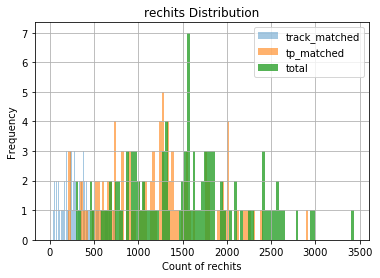

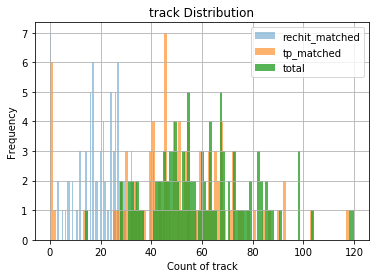

In [34]:
plot_matched_vs_unmatched(rechit_count_, ['track_matched', 'tp_matched', 'total'], 'rechits')
plot_matched_vs_unmatched(track_count_, ['rechit_matched', 'tp_matched', 'total'], 'track')

## Compare Track and Matched Rechit Eta

In [35]:
%%time

'''
Calculate the difference in track and rechit eta per event
Note: Gets Rechit Eta Values from Rechit Global DF
'''

# lists of delta-eta between tracks and matched rechits indexed by global_track_id
# also contains the mean of these values stored in a separate array using index 'mean_difference'
matched_track_eta_difference_ = {}

for event_id_ in range(number_of_events_):
    #event_df_ = track_global_df_[track_global_df_['event_id']==event_id_]
    # iterate over the selected tracks and the rechit ids matched to each track
    matched_track_eta_difference_[event_id_] = {}
    for track_id_ in track_ids_['rechit_matched'][event_id_]:
        trk_eta_diff_ = []
        track_id_ = int(track_id_)
        # Retrieve eta for the track
        trk_eta_ = track_param_global_df_.iloc[track_id_]['track_eta']
        rechit_ids_for_track_ = track_global_df_.iloc[track_id_]['rechit_ids']
        for rechit_id_ in rechit_ids_for_track_:
            rechit_id_ = int(rechit_id_)
            trk_eta_diff_.append(trk_eta_ - rechit_param_global_df_.iloc[rechit_id_]['rechit_eta'])
        matched_track_eta_difference_[event_id_][track_id_] = trk_eta_diff_
    matched_track_eta_difference_[event_id_]['mean_difference'] = [sum(diff_list_)/len(diff_list_) for diff_list_ in matched_track_eta_difference_[event_id_].values()] 
    


CPU times: user 4.7 s, sys: 36.8 ms, total: 4.74 s
Wall time: 4.72 s


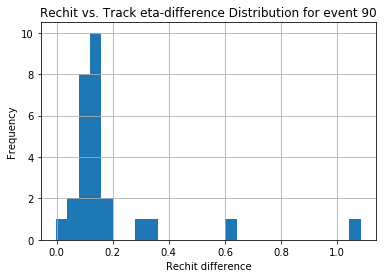

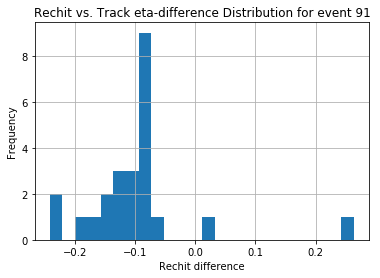

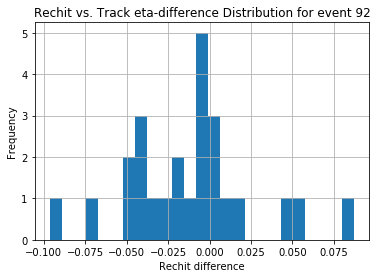

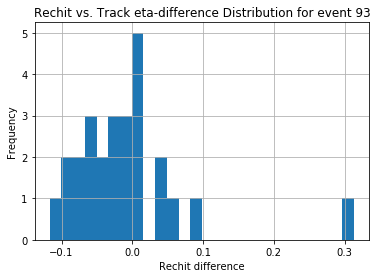

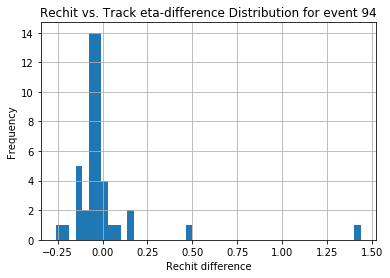

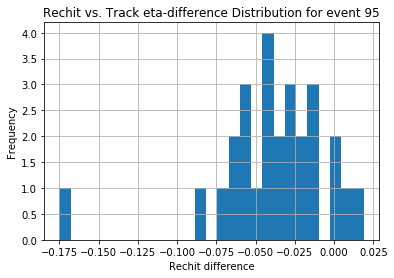

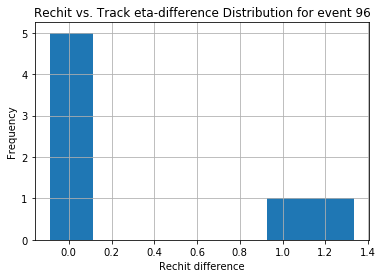

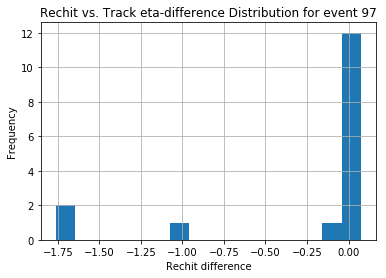

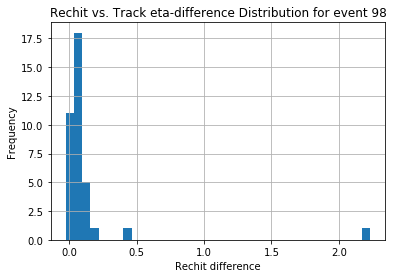

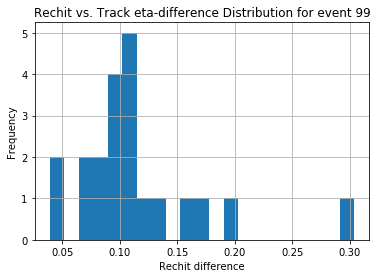

In [36]:
'''
Visualize the Difference in Eta between tracks and rechits belonging to the same track.
Repeat for SPECIFIED NUMBER OF events in the dataset.
'''

# TODO: Try to make this an aminated single graph constantly updating
# Issue: Matplotlib has problems with 'inline' and 'notebook' 
# (interactive plots) used in the same Jupyter Notebook

# plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('alpha', ['0.2', '0.4', '0.6', '0.8'])))
# print rechit_param_global_df_.iloc[:50]['rechit_eta']

for event_id_ in range(len(matched_track_eta_difference_.keys())-10, len(matched_track_eta_difference_.keys())):
    if len(matched_track_eta_difference_[event_id_]['mean_difference']) == 0:
        continue
    ax_ = plt.subplot()
    ax_.hist(matched_track_eta_difference_[event_id_]['mean_difference'], histtype='stepfilled', 
             bins=len(matched_track_eta_difference_[event_id_]['mean_difference']), 
             orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    plt.xlabel('Rechit difference')
    plt.title('Rechit vs. Track eta-difference Distribution for event ' + str(event_id_))
    #plt.savefig('plots/' + gen_event_ + '/track/' + key + 'tracks')
    plt.show()
    #plt.pause(2)
    

## Plot Track Parameters

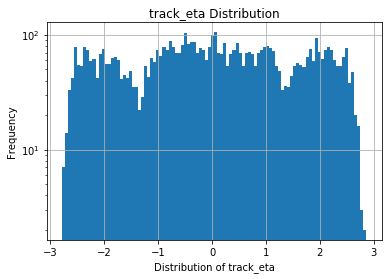

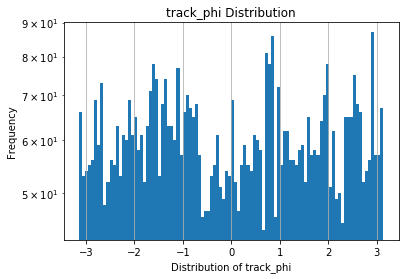

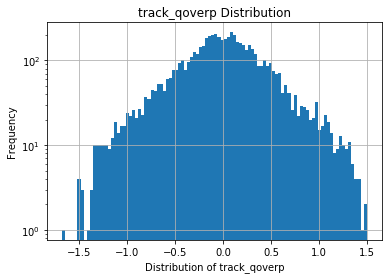

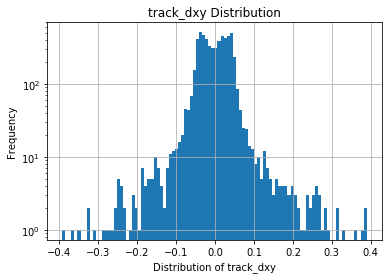

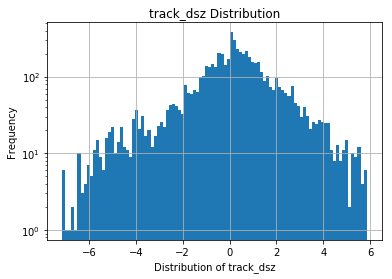

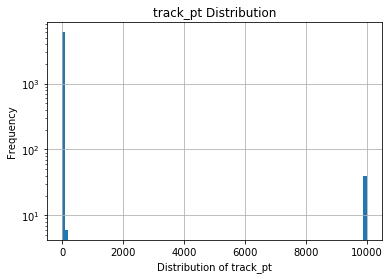

In [37]:
%matplotlib inline
# Iterate over 5 track parameters and plot their distribution
# Note: THIS IS LOG SCALE

for key in track_param_global_df_.columns:
    if key == 'track_id':
        continue
    ax_ = plt.subplot()
    ax_.hist(track_param_global_df_[key], histtype='stepfilled', bins=100, orientation='vertical')
    plt.grid(True)
    plt.ylabel('Frequency')
    
    # Comment the next line for a linear scale
    plt.yscale('log')
    
    plt.xlabel('Distribution of ' + key)
    plt.title(key + ' Distribution')
    plt.savefig('plots/' + gen_event_ + '/track/' + key)
    plt.show()

### Filter High-Pt Events

Iterating over track pt from 6041 tracks


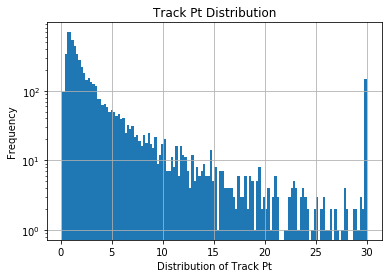

In [38]:
# Additional visualization discarding high-pt events for more clarity

track_pt_ = data_.array('trackPt')
concat_track_pt_ = []
high_pt_events_ = {}

for event_ in range(len(track_pt_)):
    for trk_pt_val_ in track_pt_[event_]:
        
        # What is a reasonable general threshold for Track Pt?
        if trk_pt_val_ < 30:
            concat_track_pt_.append(trk_pt_val_)
        else:
            if event_ in high_pt_events_:
                high_pt_events_[event_] += 1
            else:
                high_pt_events_[event_] = 1
            concat_track_pt_.append(30)
            
print "Iterating over track pt from", len(concat_track_pt_), "tracks"

plt.clf()
ax_ = plt.subplot()
ax_.hist(concat_track_pt_, histtype='stepfilled', bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Frequency')
plt.yscale('log')
plt.xlabel('Distribution of Track Pt')
plt.title('Track Pt Distribution')
plt.savefig('plots/' + gen_event_ + '/track/track-pt')
plt.show()

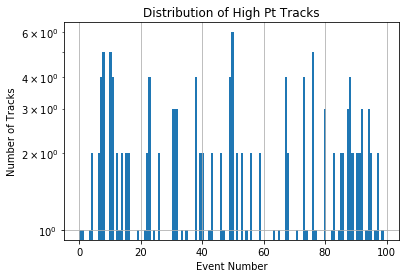

In [39]:
# Events with high pt tracks and their distribution

plt.clf()
ax_ = plt.subplot()
ax_.hist(high_pt_events_.keys(), weights=high_pt_events_.values(), bins=len(high_pt_events_.keys())*2, orientation='vertical')
plt.grid(True)
plt.ylabel('Number of Tracks')
plt.yscale('log')
plt.xlabel('Event Number')
plt.title('Distribution of High Pt Tracks')
plt.savefig('plots/' + gen_event_ + '/track/high-pt-events')
plt.show()


# Plot SimHit Distribution in X and Y Axes

In [40]:
%matplotlib inline

def plot_2d_rechit_parameters(params_, rechit_type_, n_bins_=300, figsize_x_=10, figsize_y_=10, uncut_rechit_ids_=None):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i: str

    :rtype: None 
    '''
    # Add updates to filter uncut Rechit IDs
    if uncut_rechit_ids_ is not None:
        print "Method not defined to filter by uncut ids"
    else:
        x_coordinate_ = data_.array(params_[0])
        y_coordinate_ = data_.array(params_[1])

        if len(x_coordinate_) == len(y_coordinate_):
            concat_x_ = []
            concat_y_ = []

            for i in range(len(x_coordinate_)):
                concat_x_.extend(x_coordinate_[i])
                concat_y_.extend(y_coordinate_[i])

        plt.figure(figsize=(figsize_x_, figsize_y_))
        ax_ = plt.subplot(1,1,1)
        plt.xlabel(params_[0])
        plt.ylabel(params_[1])
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + ' Distribution')
        ax_.patch.set_facecolor('black')
        ax_.hist2d(concat_x_, concat_y_, bins=n_bins_, norm=matplotlib.colors.LogNorm(), cmap='hot')
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/2drechitdistribution')
        plt.show()
    return

In [41]:
%matplotlib inline
'''
Function to plot the rechit parameters as a histogram
'''
def plot_rechit_parameters(params_, rechit_type_, n_bins_=50, figsize_x_=8, figsize_y_=6):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i_: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i_: str

    :rtype: None 
    '''
    # Define a loop that plots R, Phi, and Eta for Rechits
    for property_ in params_:
        param_array_ = data_.array(property_)
        concat_param_array_ = []

        for i in range(len(param_array_)):
                concat_param_array_.extend(param_array_[i])

        plt.clf()
        fig, ax_ = plt.subplots(figsize=(figsize_x_, figsize_y_))
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + 'Rechit Distribution of ' + property_)
        ax_.hist(concat_param_array_, bins=n_bins_, histtype='stepfilled', align='mid', orientation='vertical')
        plt.xlabel('Value of ' + property_)
        plt.ylabel('Distribution of ' + property_)
        plt.title(property_ + ' Distribution')
        plt.grid(True)
        plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/' + property_)
        plt.show()
    return

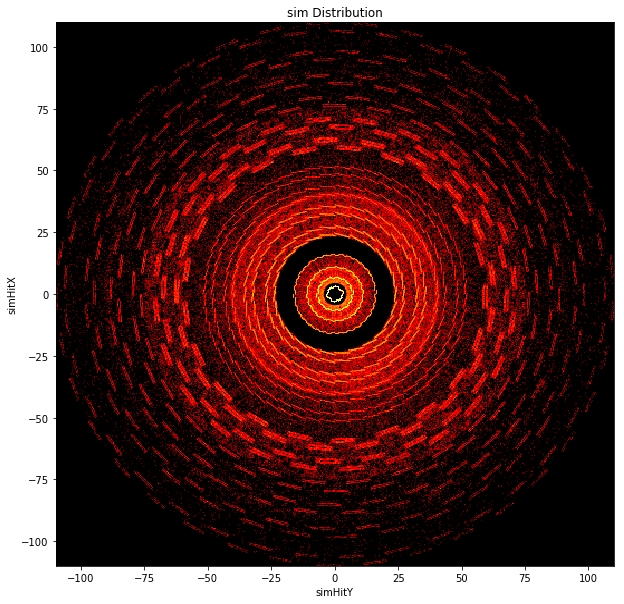

In [42]:
plot_2d_rechit_parameters(["simHitY", "simHitX"], 'sim', n_bins_=500)

### Count Simhits Matched to Tracks

In [43]:
%%time
'''
Extract the Simhits Matched to Tracks already from the C++ code
'''

# Count the simhit matches to tracks
simhit_tp_match_ = data_.array("simHitMatch")
simhit_count_ = {'track_matched': [], 'total': []}

for event_id_ in range(number_of_events_):
    match_count_ = 0
    for tp_ in simhit_tp_match_[event_id_]:
        # Change this to == 0 in the next set of ttbar outfiles
        if tp_ > 0:
            match_count_ += 1
        else:
            continue
    simhit_count_['total'].append(len(simhit_tp_match_[event_id_]))
    simhit_count_['track_matched'].append(match_count_)

count_total_ = []
count_matched_ = []
print "Event, Total Hit Count, Matched Hit Count"

for i in range(number_of_events_):
    count_total_.append(simhit_count_['total'][i])
    count_matched_.append(simhit_count_['track_matched'][i])
    if simhit_count_['track_matched'][i] == 0:
        print i, "\t", simhit_count_['total'][i], "\t", simhit_count_['track_matched'][i]

print float(sum(count_matched_))/float(sum(count_total_))

Event, Total Hit Count, Matched Hit Count
7 	472505 	0
8 	714058 	0
10 	446368 	0
29 	464284 	0
77 	205020 	0
88 	529569 	0
0.00279273372853
CPU times: user 1min 7s, sys: 710 ms, total: 1min 8s
Wall time: 1min 8s


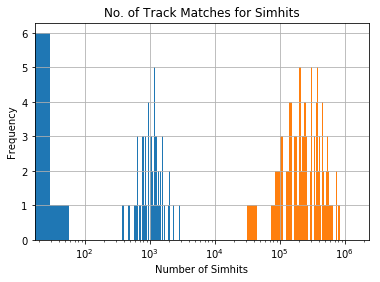

In [44]:
plt.clf()
ax_ = plt.subplot()
ax_.hist(simhit_count_['track_matched'], bins=len(simhit_count_['track_matched']), orientation='vertical', label='track_matched simhits')
ax_.hist(simhit_count_['total'], bins=len(simhit_count_['total']), orientation='vertical', label='track_matched simhits')
plt.grid(True)
plt.ylabel('Frequency')
plt.xlabel('Number of Simhits')
plt.xscale('log')
plt.title('No. of Track Matches for Simhits')
#plt.savefig('plots/' + gen_event_ + '/simhit/track-matches')
plt.show()

### Plot the Hole in the Data (2D Plot; 3D Axes)

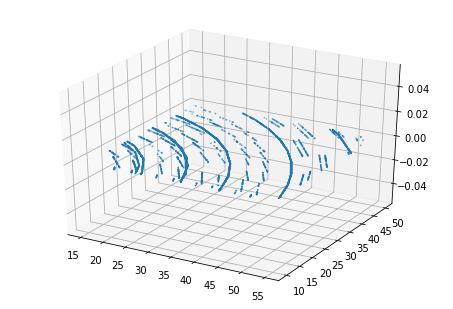

In [45]:
%matplotlib inline

# Trying to explore the hole in 3 dimensions
# Not quite possible to do manually?
fig_ = plt.figure()
ax_ = Axes3D(fig_)

mono_x_ = data_.array('monoHitX')
mono_y_ = data_.array('monoHitY')
mono_z_ = data_.array('monoHitZ')

concat_mono_x_ = []
concat_mono_y_ = []
concat_mono_z_ = []

for event_ in range(10):
    for x, y, z, in zip(mono_x_[event_], mono_y_[event_], mono_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_mono_x_.append(x)
            concat_mono_y_.append(y)
            concat_mono_z_.append(z)   

ax_.scatter3D(concat_mono_x_, concat_mono_y_, s=0.6)
#ax_.scatter3D(concat_mono_x_, concat_mono_y_, concat_mono_z_, s=0.6)

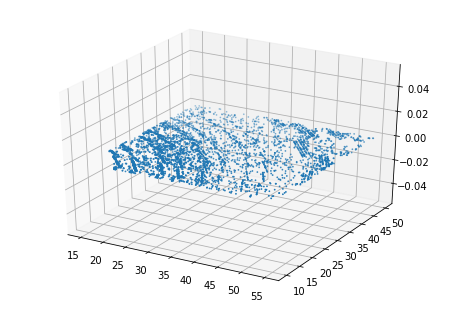

In [46]:
% matplotlib inline

# These are the SIMHITS lying along the same cross-section
# Clearly there is no hole in the Simhits

fig_ = plt.figure()
ax_ = Axes3D(fig_)

simhit_x_ = data_.array('simHitX')
simhit_y_ = data_.array('simHitY')
simhit_z_ = data_.array('simHitZ')

concat_simhit_x_ = []
concat_simhit_y_ = []
concat_simhit_z_ = []

for event_ in range(8):
    for x, y, z, in zip(simhit_x_[event_], simhit_y_[event_], simhit_z_[event_]):
        if x < 55 and x > 15 and y > 10 and y < 50:
            concat_simhit_x_.append(x)
            concat_simhit_y_.append(y)
            concat_simhit_z_.append(z)   

ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, s=0.6)  # Better visualization
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

### Visualize the Mono Rechits

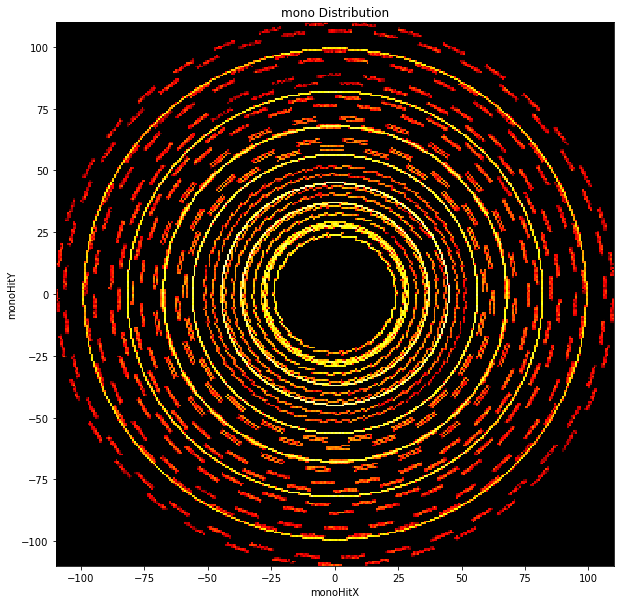

In [47]:
plot_2d_rechit_parameters(["monoHitX", "monoHitY"], 'mono')

## Plot Rechit Parameters

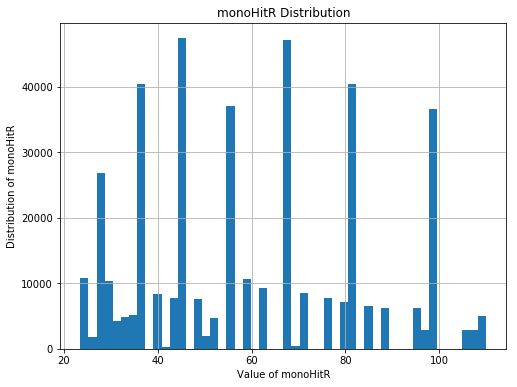

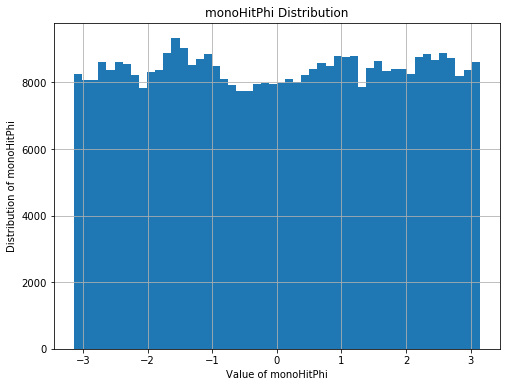

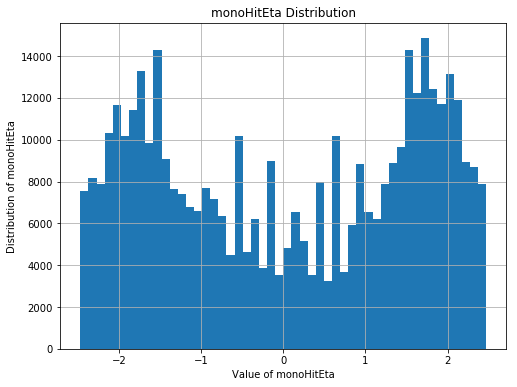

In [48]:
# Call the plot function to plot histograms of rechit parameters
plot_rechit_parameters(["monoHitR", "monoHitPhi", "monoHitEta"], 'mono')

## Visualize the Stereo Rechits

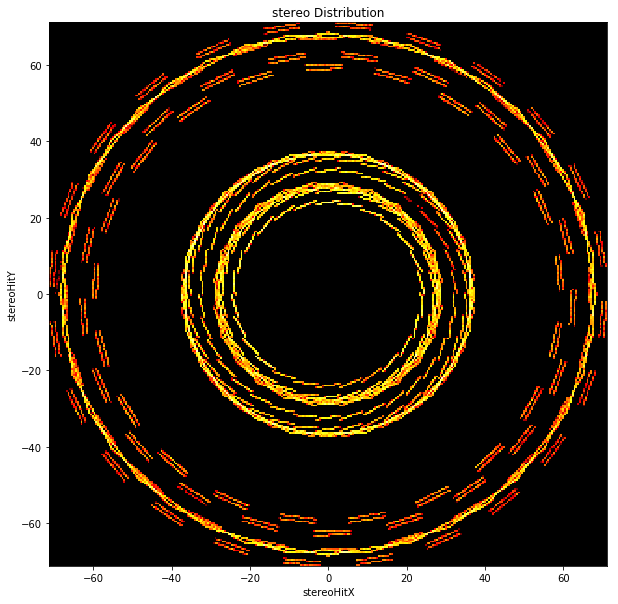

In [49]:
plot_2d_rechit_parameters(["stereoHitX", "stereoHitY"], 'stereo')

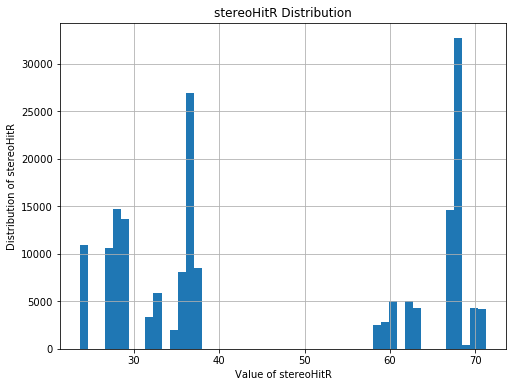

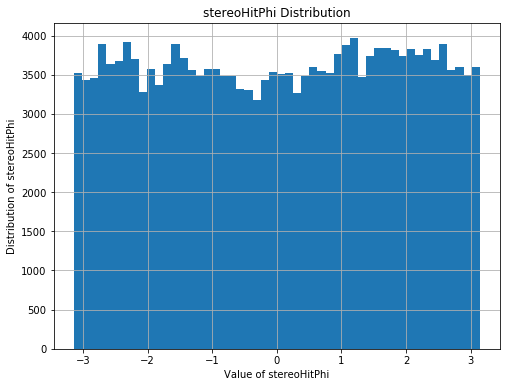

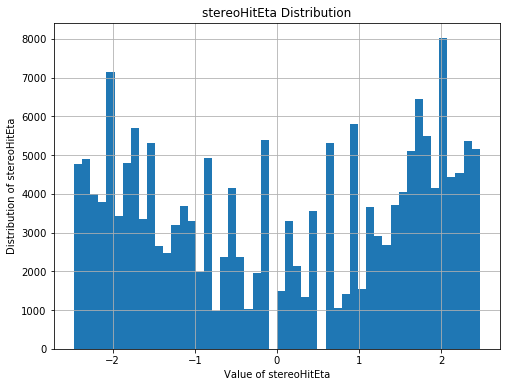

In [50]:
# Plot R, Phi, and Eta for Stereo Hits
plot_rechit_parameters(["stereoHitR", "stereoHitPhi", "stereoHitEta"], 'stereo')


### Testing Integrity of internal data storage 

In [51]:
%%time
# Correlate the data to confirm the dataframe has not been corrupted
hit_tp_count_ = {}

for (id_, tp_idx_list_) in rechit_global_df_["rechit_tp_index"].iteritems():
    tp_len_ = len(tp_idx_list_)
    if tp_len_ in hit_tp_count_:
        hit_tp_count_[tp_len_] += 1
    else:
        hit_tp_count_[tp_len_] = 1
print hit_tp_count_

{0: 30627, 1: 120657, 2: 1265, 3: 65, 4: 9, 5: 2, 6: 2, 8: 1, 9: 2}
CPU times: user 84 ms, sys: 5.07 ms, total: 89 ms
Wall time: 76 ms


## Data Storage for TF/PyTorch/Graph Library

In [52]:
'''DataFrame Documentation for Pandas states that writing and reading from msgpack is an experimental feature.
It is to be released soon, but please use it with care to ensure data is not corrupted.

Note: When working with large datasets (>1000 events), you will not be able to save the data.
The filesize for rechit_global_df_ is 76 MB for 100 events thus 760 MB for 1000 events and so on.'''

'DataFrame Documentation for Pandas states that writing and reading from msgpack is an experimental feature.\nIt is to be released soon, but please use it with care to ensure data is not corrupted.\n\nNote: When working with large datasets (>1000 events), you will not be able to save the data.\nThe filesize for rechit_global_df_ is 76 MB for 100 events thus 760 MB for 1000 events and so on.'

In [53]:
%%time
'''
Writing to serialized format fails in case of copied dataframes as the columns are sets

Solution: Iterate over all Global DataFrames, find the columns to replace, 
and replace with lists instead of sets so that they are serializable
'''

i = 0
# List of strings with dataframe names to set as filenames for storage
name_list_ = ['data/track_global_df_', 'data/track_param_global_df_', 
              'data/rechit_global_df_', 'data/rechit_param_global_df_']

for dataframe_ in [track_global_df_, track_param_global_df_, rechit_global_df_, rechit_param_global_df_]:
    dataframe_to_update_ = dataframe_.copy(deep=True)
    columns_to_replace_ = ['rechit_ids', 'rechit_local_ids', 'rechit_tp_index', 'track_tp_index', 'track_matches']
    for column_name_ in columns_to_replace_:    
        if column_name_ in dataframe_to_update_:
            list_arr_ = []
            for set_ in dataframe_to_update_[column_name_]:
                list_arr_.append(list(set_))
            dataframe_to_update_.update(pd.Series(list_arr_, name=column_name_))
    filename_ =  name_list_[i] + '.msgpack'
    dataframe_to_update_.to_msgpack(filename_, encoding='utf-8')
    i += 1


CPU times: user 1.87 s, sys: 60.9 ms, total: 1.93 s
Wall time: 1.94 s


In [54]:
%%time
track_global_df_ = pd.read_msgpack('data/track_global_df_.msgpack', encoding='utf-8')
track_param_global_df_ = pd.read_msgpack('data/track_param_global_df_.msgpack', encoding='utf-8')
rechit_global_df_ = pd.read_msgpack('data/rechit_global_df_.msgpack', encoding='utf-8')
rechit_param_global_df_ = pd.read_msgpack('data/rechit_param_global_df_.msgpack', encoding='utf-8')

CPU times: user 594 ms, sys: 26.6 ms, total: 620 ms
Wall time: 619 ms


In [55]:
%%time
'''
This is for future compatibility to allow extraction of data in any format necessary

Write the dictionaries containing matched/unmatched rechit/track data to CSV files
Read them back to confirm that the data is not corrupted or altered in any manner
'''

#names_of_csv_files_ = ['data/track_count_.csv', 'data/rechit_count_.csv', 
                       #'data/track_ids_.csv', 'data/rechit_ids_.csv']    
#dicts_to_csv_ = [track_count_, rechit_count_, track_ids_, rechit_ids_]
#for i in range(len(names_of_csv_files_)):    

pd.DataFrame.from_dict(track_count_).to_csv('data/track_count_.csv', index=False)
pd.DataFrame.from_dict(rechit_count_).to_csv('data/rechit_count_.csv', index=False)
pd.DataFrame.from_dict(track_ids_).to_csv('data/track_ids_.csv', index=False)
pd.DataFrame.from_dict(rechit_ids_).to_csv('data/rechit_ids_.csv', index=False)

track_count_ = pd.DataFrame.to_dict(pd.read_csv('data/track_count_.csv'))
rechit_count_ = pd.DataFrame.to_dict(pd.read_csv('data/rechit_count_.csv'))
track_ids_ = pd.DataFrame.to_dict(pd.read_csv('data/track_ids_.csv'))
rechit_ids_ = pd.DataFrame.to_dict(pd.read_csv('data/rechit_ids_.csv'))


CPU times: user 5.6 s, sys: 64.6 ms, total: 5.66 s
Wall time: 5.72 s


## Place the Cuts on Rechits => eta (-0.9, 0.9)

In [56]:
# Use the list of remaining rechits to filter the global rechit index
# Done: Move this cell to a location before the tracks are matched to rechits
# Thus you automatically match only the hits that are valid given the cut

rechit_param_global_df_cut_ = rechit_param_global_df_.copy()
rechit_global_df_cut_ = rechit_global_df_.copy()

print len(rechit_global_df_cut_), "entries in global rechit df"

# Create a dict/hash map of the modified indices for searching efficiently
# This seems faster than checking rechit_id in the dataframe each time
uncut_rechit_id_map_ = {}
for (idx_, item_) in rechit_param_global_df_cut_['rechit_id'].iteritems():
    uncut_rechit_id_map_[item_] = idx_

# Check that the ID Ordering scheme in the global rechit ordered dicts has 
# not changed as a result of dropping the rechits that have been cut

for x,y in zip(rechit_global_df_cut_['rechit_id'], rechit_param_global_df_cut_['rechit_id']):
    if x != y:
        print ("Rechit ID Mismatch: ", x, y)

152630 entries in global rechit df


In [57]:
%%time
'''
Modify the uncut_rechit_id_map_ to work on a per-event basis.
This is done to speed up building the adjacency matrix for the graph based on checking (per id) if a rechit is cut or uncut.
Now we can check rechit IDs as being uncut on a per-event basis for each track in the event.

#TODO: Arguably this is pointless if Python set access is O(1) because either way we can use sets and size doesn't matter,
but we can compare that at a later point.'''

uncut_rechit_ids_per_event_ = []
for event_id_ in range(number_of_events_):
    rechit_event_df_ = rechit_global_df_cut_[rechit_global_df_cut_['event_id']==event_id_]
    uncut_rechit_ids_per_event_.append(rechit_event_df_['rechit_id'].tolist())


CPU times: user 81.9 ms, sys: 2.57 ms, total: 84.5 ms
Wall time: 84.7 ms


In [58]:
np.save('data/uncut_rechit_ids_', np.array(uncut_rechit_ids_per_event_))
uncut_rechit_ids_reloaded_ = np.load('data/uncut_rechit_ids_.npy')

In [59]:
'''Assert that the read and written are equal in all respects and file-writing does not corrupt data.'''
for i in range(number_of_events_):
    for (j, k) in zip(uncut_rechit_ids_per_event_, uncut_rechit_ids_reloaded_):
        if j == k:
            continue
        else:
            print "Error: Mismatch in read and written arrays"

## Visualize Subset of Tracks with and without Cuts

In [60]:
import matplotlib.pyplot as plt

In [61]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    #print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

/Users/swappy/Documents/anaconda/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Skipped all rechits in track 21
Skipped all rechits in track 28


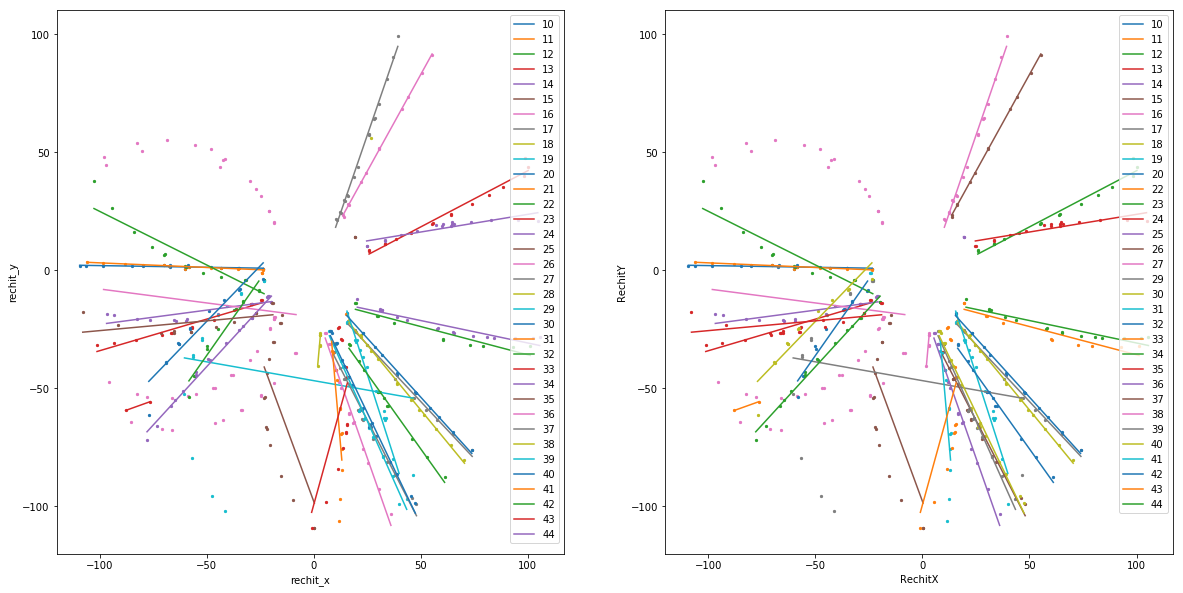

In [62]:
% matplotlib inline
# Plot the tracks that have been matched to rechits (WITHOUT THE CUT)

# Set a criteria to filter only tracks matched to actual hits
criteria_ = [(len(rechit_id_list_) > 0) for rechit_id_list_ in track_global_df_['rechit_ids']]
track_matched_hit_ids_ = track_global_df_[criteria_]['rechit_ids']

# Verify that you have selected the correct tracks with matched rechits
assert len(track_matched_hit_ids_) == len(track_global_df_[track_global_df_['match_count'] > 0]), \
"Incorrect tracks selected; re-check count of tracks matched to rechits"


#def plot_filtered_tracks(key, tracks_begin_=10, tracks_end_=45):
fig_ = plt.figure(figsize=[20, 10])
ax_ = plt.subplot(121)

event_id_ = 10
tracks_begin_, tracks_end_ = 10, 45

# Num_tracks should be less thatn the number of actual tracks matched to hits

for i in range(tracks_begin_, tracks_end_):
    matched_hit_x_ = []
    matched_hit_y_ = []
    #matched_hit_z_ = []
    for matched_id_ in track_matched_hit_ids_.iloc[i]:
        matched_hit_x_.append(rechit_param_global_df_.loc[matched_id_, ('rechit_x')]) 
        matched_hit_y_.append(rechit_param_global_df_.loc[matched_id_, ('rechit_y')]) 
        #matched_hit_z_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_z'])   
    #sorted_x_, sorted_y_, sorted_z_ = zip(*sorted(zip(matched_hit_x_, matched_hit_y_, matched_hit_z_)))
    sorted_x_, sorted_y_= zip(*sorted(zip(matched_hit_x_, matched_hit_y_)))
    plt.scatter(matched_hit_x_, matched_hit_y_, s=5)
    a, b = best_fit(sorted_x_, sorted_y_)
    yfit = [a + b * xi for xi in sorted_x_]
    plt.plot(sorted_x_, yfit, label=i) # Best-fit line visualization
plt.xlabel('rechit_x')
plt.ylabel('rechit_y')
#plt.zlabel('RechitZ')
plt.legend()
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)


ax_ = plt.subplot(122)

for i in range(tracks_begin_, tracks_end_):
    matched_hit_x_ = []
    matched_hit_y_ = []
    #matched_hit_z_ = []
    for matched_id_ in track_matched_hit_ids_.iloc[i]:
        if matched_id_ in uncut_rechit_id_map_:
            matched_hit_x_.append(rechit_param_global_df_.loc[matched_id_, ('rechit_x')]) 
            matched_hit_y_.append(rechit_param_global_df_.loc[matched_id_, ('rechit_y')]) 
            #matched_hit_z_.append(rechit_param_global_df_.loc[matched_id_, ('rechit_z')])
    if len(matched_hit_x_) <= 1:
        print "Skipped all rechits in track", i
        continue
    #sorted_x_, sorted_y_, sorted_z_ = zip(*sorted(zip(matched_hit_x_, matched_hit_y_, matched_hit_z_)))
    sorted_x_, sorted_y_= zip(*sorted(zip(matched_hit_x_, matched_hit_y_)))
    plt.scatter(matched_hit_x_, matched_hit_y_, s=5)
    a, b = best_fit(sorted_x_, sorted_y_)
    yfit = [a + b * xi for xi in sorted_x_]
    plt.plot(sorted_x_, yfit, label=i) # Best-fit line visualization
    #plt.plot(sorted_x_, sorted_y_, label=i) # Better visualization
plt.xlabel('RechitX')
plt.ylabel('RechitY')
#plt.zlabel('RechitZ')
plt.legend()
plt.savefig('plots/ttbar-100/track/reconstruction')

### Plot the Hits without Connections

Skipped all rechits in track 4


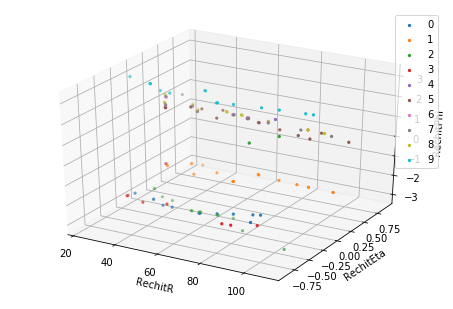

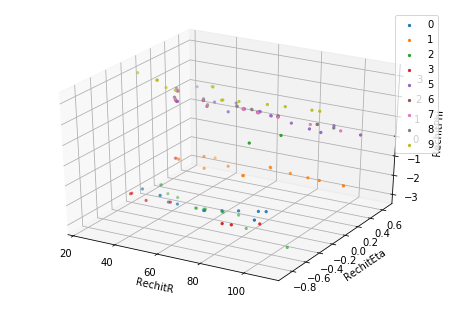

In [63]:
% matplotlib inline

# Plot the tracks that have been matched to rechits (WITHOUT THE CUT)

# Set a criteria to filter only tracks matched to hits
criteria_ = [(len(rechit_id_list_) > 0) for rechit_id_list_ in track_global_df_['rechit_ids']]
track_matched_hit_ids_ = track_global_df_[criteria_]['rechit_ids']

# Verify that you have selected the correct tracks with matched rechits
assert len(track_matched_hit_ids_) == len(track_global_df_[track_global_df_['match_count'] > 0]), \
"Incorrect tracks selected; re-check count of tracks matched to rechits"

fig_ = plt.figure()
ax_ = Axes3D(fig_)

# Defined in previous cell
tracks_begin_, tracks_end_ = 0, 10
# TODO: Select tracks by event_id
event_id_ = 15
filtered_rechit_ids_from_track_cuts_ = {}
# Num_tracks should be less thatn the number of actual tracks matched to hits

for i in range(tracks_begin_, tracks_end_):
    matched_hit_x_ = []
    matched_hit_y_ = []
    matched_hit_z_ = []
    for matched_id_ in track_matched_hit_ids_.iloc[i]:
        matched_hit_x_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_r']) 
        matched_hit_y_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_eta']) 
        matched_hit_z_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_phi'])   
    sorted_x_, sorted_y_, sorted_z_ = zip(*sorted(zip(matched_hit_x_, matched_hit_y_, matched_hit_z_)))
    ax_.scatter3D(matched_hit_x_, matched_hit_y_, matched_hit_z_, s=5, label=i)
    #ax_.plot(sorted_x_, sorted_y_, sorted_z_, label=i)# Better visualization
plt.xlabel('RechitR')
plt.ylabel('RechitEta')
ax_.set_zlabel('RechitPhi')
plt.legend()
# ax_.scatter3D(concat_simhit_x_, concat_simhit_y_, concat_simhit_z_, s=0.6)

fig_ = plt.figure()
ax_ = Axes3D(fig_)

for i in range(tracks_begin_, tracks_end_):
    matched_hit_x_ = []
    matched_hit_y_ = []
    matched_hit_z_ = []
    filtered_rechit_ids_from_track_cuts_[i] = []
    for matched_id_ in track_matched_hit_ids_.iloc[i]:
        if matched_id_ in uncut_rechit_id_map_:
            matched_hit_x_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_r']) 
            matched_hit_y_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_eta'])
            matched_hit_z_.append(rechit_param_global_df_.iloc[matched_id_]['rechit_phi'])
            filtered_rechit_ids_from_track_cuts_[i].append(matched_id_)
    if len(matched_hit_x_) <= 1:
        print "Skipped all rechits in track", i
        continue
    sorted_x_, sorted_y_, sorted_z_ = zip(*sorted(zip(matched_hit_x_, matched_hit_y_, matched_hit_z_)))
    # REMOVED Y AXIS ENTIRELY (R-PHI) -------------------------------------------------------------------------
    ax_.scatter(matched_hit_x_, matched_hit_y_, matched_hit_z_, s=5, label=i)
    #ax_.plot(sorted_x_, sorted_y_, sorted_x_, sorted_z_, label=i)# Better visualization
plt.xlabel('RechitR')
plt.ylabel('RechitEta')
ax_.set_zlabel('RechitPhi')
plt.legend()

### Plot the 2D Rechit Parameters for Filtered Hits

In [64]:
# TODO: This function can be combined with the previously defined 'plot_2d_rechit_parameters'

def plot_filtered_2d_rechit_parameters(params_, rechit_type_, n_bins_=300, figsize_x_=10, figsize_y_=10, uncut_rechit_ids_=None, ax_=None):
    '''
    Plot any 2 dimensional representation of the rechits 
    :param params_: 2-element list of parameters to plot
    :param rechit_type_: name of folder to store the file in
    :param n_bins_: int
    :param figsize_i: size of figure in inches along 'i' axis (i := x or y)

    :type params_: list(str)
    :type rechit_type_: str
    :type n_bins_: int
    :type figsize_i: str

    :rtype: None 
    '''
    if ax_ is None:
        plt.figure(figsize=(figsize_x_, figsize_y_))
        ax_ = plt.subplot(1,1,1)
        
    x_coordinate_ = rechit_param_global_df_[params_[0]]
    y_coordinate_ = rechit_param_global_df_[params_[1]]
    concat_x_ = []
    concat_y_ = []
    # Add updates to filter uncut Rechit IDs    
    if uncut_rechit_ids_ is not None:
        for track_id_ in uncut_rechit_ids_:
            concat_x_ = []
            concat_y_ = []
            for id_ in uncut_rechit_ids_[track_id_]:    
                concat_x_.append(x_coordinate_[id_])
                concat_y_.append(y_coordinate_[id_])
            ax_.scatter(concat_x_, concat_y_, alpha=0.9, label=track_id_)
        plt.xlabel(params_[0])
        plt.ylabel(params_[1])
        # Plot the 2D Histogram for Rechit Parameters
        ax_.set_title(rechit_type_ + ' Distribution')
        plt.legend()
        
    else:
        print("No uncut rechit ID List provided")
        for i in range(len(x_coordinate_)):
            concat_x_.append(x_coordinate_[i])
            concat_y_.append(y_coordinate_[i])
   
        plt.xlabel(params_[0])
        plt.ylabel(params_[1])
        # Plot the 2D Histogram for Mono Rechits
        ax_.set_title(rechit_type_ + ' Distribution')
        ax_.patch.set_facecolor('black')
        ax_.hist2d(concat_x_, concat_y_, cmap='hot')
    plt.savefig('plots/' + gen_event_ + '/' + rechit_type_ + '/2drechit' + params_[0] + params_[1] + 'distribution')
    plt.show()
    return ax_

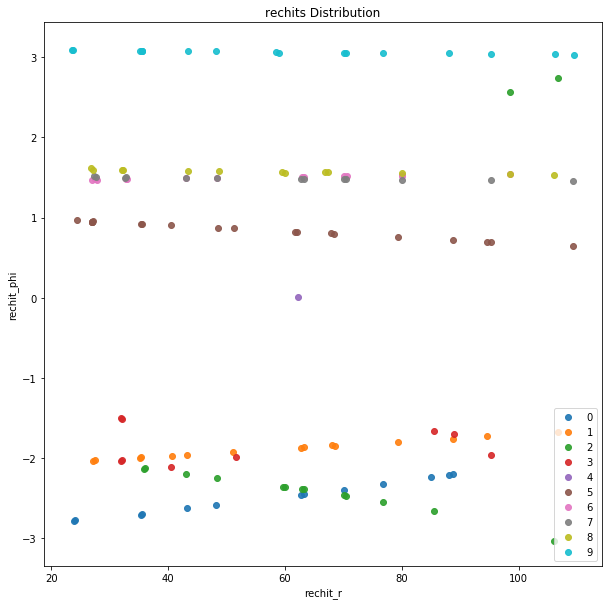

In [65]:
plot_filtered_2d_rechit_parameters(["rechit_r", "rechit_phi"], 'rechits', uncut_rechit_ids_=filtered_rechit_ids_from_track_cuts_)

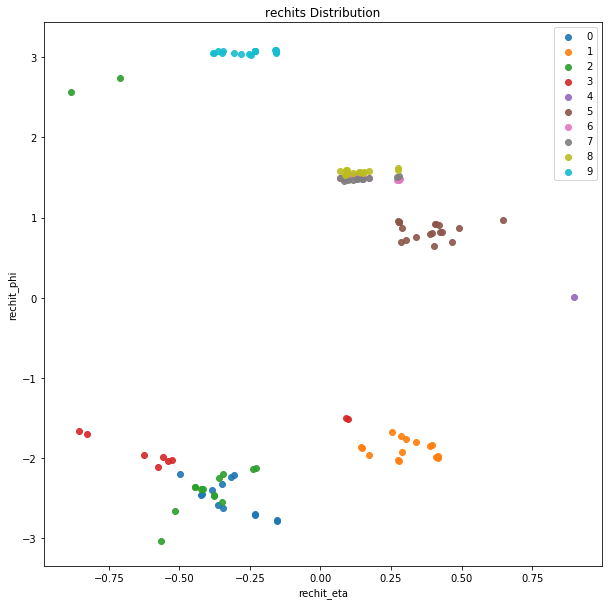

In [66]:
plot_filtered_2d_rechit_parameters(["rechit_eta", "rechit_phi"], 'rechits', uncut_rechit_ids_=filtered_rechit_ids_from_track_cuts_)

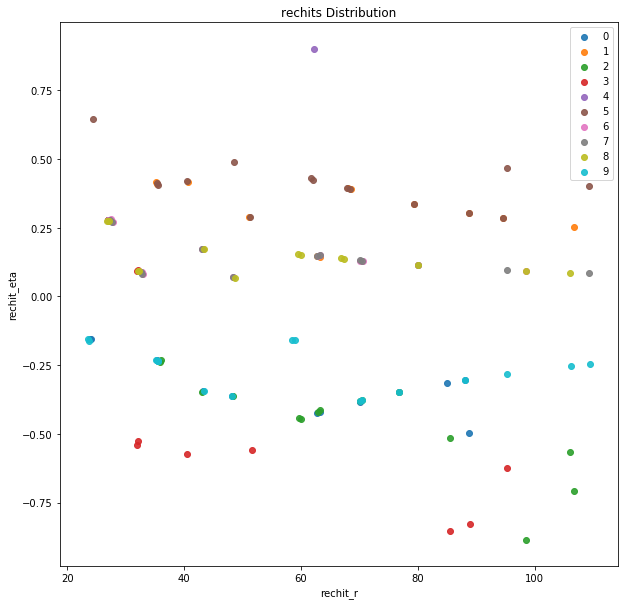

In [67]:
plot_filtered_2d_rechit_parameters(["rechit_r", "rechit_eta"], 'rechits', uncut_rechit_ids_=filtered_rechit_ids_from_track_cuts_)

## Place the cuts on tracks by Eta and Pt


In [68]:
%%time
# Moved this line to top -> replaced track_global_df_ and track_param_global_df_ with cut data
# Uncomment next line and comment next 3 lines to cut only by track_pt for checking % tracks remaining
# track_param_global_df_cut_ = track_param_global_df_[track_param_global_df_['track_pt'] <= 10]

intermediate_df_ = track_param_global_df_[track_param_global_df_['track_eta'] <= 0.9]
intermediate_df_ = intermediate_df_[intermediate_df_['track_pt'] <= 10]
intermediate_df_ = intermediate_df_[intermediate_df_['track_pt'] >= 1]
track_param_global_df_cut_ = intermediate_df_[intermediate_df_['track_eta'] >= -0.9]
print len(track_param_global_df_cut_), "of", len(track_param_global_df_), \
"(", float(len(track_param_global_df_cut_))*100/float(len(track_param_global_df_)), "%) tracks remain"

track_global_df_cut_ = track_global_df_.iloc[track_param_global_df_cut_['track_id']]
print len(track_global_df_cut_), "entries in global track df"

# Create a dict/hash map of the modified indices for searching efficiently
# This seems faster than checking rechit_id in the dataframe each time
uncut_track_id_map_ = {}
for (idx_, item_) in track_param_global_df_cut_['track_id'].iteritems():
    uncut_track_id_map_[item_] = idx_

# Check that the ID Ordering scheme in the global track ordered dicts has 
# not changed as a result of dropping the tracks that have been cut
for x,y in zip(track_global_df_cut_['track_id'], track_param_global_df_cut_['track_id']):
    if x != y:
        print "Track ID Mismatch: ", x, y

1678 of 6041 ( 27.7768581361 %) tracks remain
1678 entries in global track df
CPU times: user 7.25 ms, sys: 3.9 ms, total: 11.1 ms
Wall time: 10.6 ms


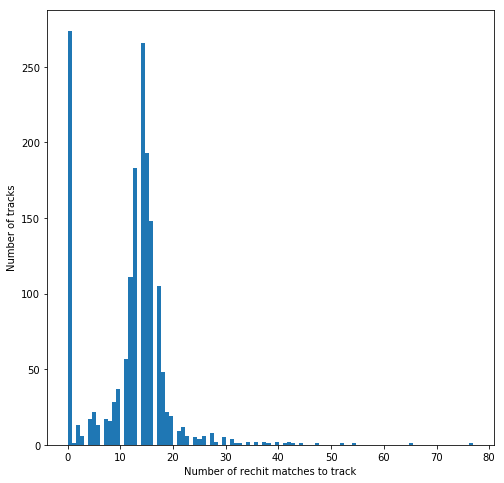

In [69]:
'''Check the average hits per track (post-filtering)'''
fig_ = plt.figure(figsize=[8, 8])
ax_ = plt.subplot(111)
ax_.hist(track_global_df_cut_['match_count'], bins=number_of_events_)
plt.xlabel("Number of rechit matches to track")
plt.ylabel("Number of tracks")
plt.show()

## Plot only the filtered rechits

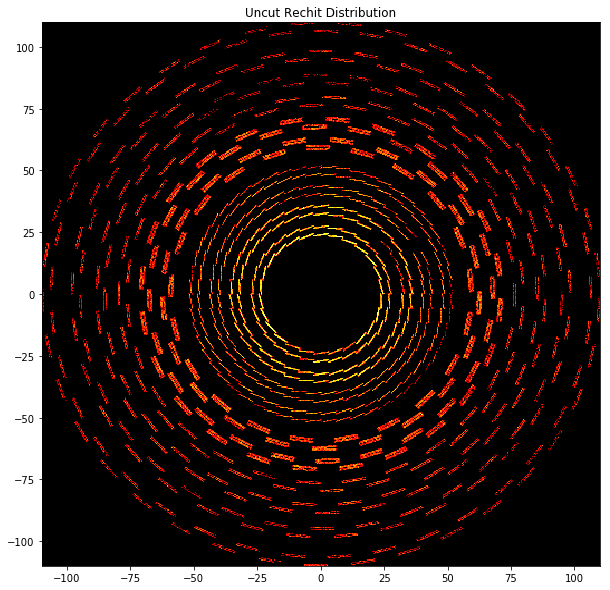

CPU times: user 4.02 s, sys: 138 ms, total: 4.16 s
Wall time: 3.87 s


In [70]:
%%time
# Append all uncut rechits into arrays (x, y) for plotting
concat_x_ = []
concat_y_ = []

hit_x_df_ = rechit_param_global_df_['rechit_x']
hit_y_df_ = rechit_param_global_df_['rechit_y']

for rechit_id_ in uncut_rechit_id_map_:
    concat_x_.append(hit_x_df_[uncut_rechit_id_map_[rechit_id_]])
    concat_y_.append(hit_y_df_[uncut_rechit_id_map_[rechit_id_]])

plt.figure(figsize=(10,10))
ax_ = plt.subplot(1,1,1)
# Plot the 2D Histogram for Mono Rechits
ax_.set_title('Uncut Rechit Distribution')
ax_.patch.set_facecolor('black')
ax_.hist2d(concat_x_, concat_y_, bins=500, norm=matplotlib.colors.LogNorm(), cmap='hot')
plt.savefig('plots/' + gen_event_ + '/rechits/uncutrechitdistribution')
plt.show()

## Plot Track Distribution

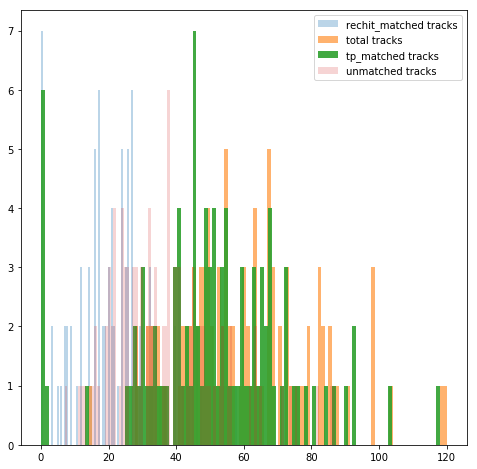

In [71]:
'''The figure tells us how the tracks are distributed on average.
Note that unmatched tracks usually rank low on the spectrum (0-20 per event)
at least for 100 events.'''

fig_ = plt.figure(figsize=[8, 8])
ax_ = plt.subplot(121)
alpha_ = 0.3
for key in track_count_.keys():
    ax_ = plt.subplot(111)
    ax_.hist(track_count_[key].values(), bins=number_of_events_, histtype='stepfilled', \
             orientation='vertical', alpha=alpha_, label=key + ' tracks')
    alpha_ += 0.3
plt.legend()